In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

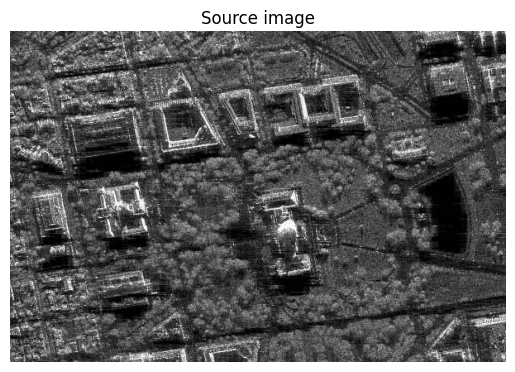

In [4]:
# 1. Загрузите изображение в оттенках серого sar_1_gray.jpg.

img = cv2.imread('sar_1_gray.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title("Source image")
plt.axis('off')
plt.show()

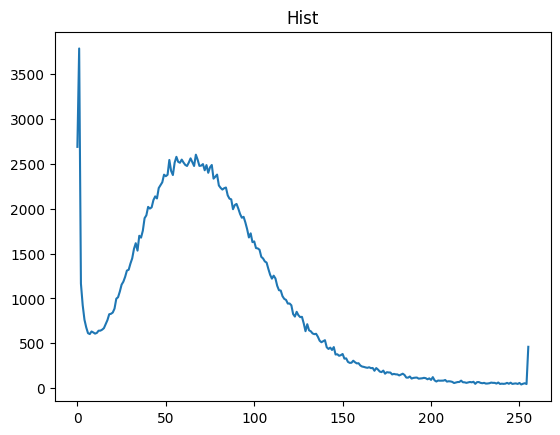

In [6]:
# 2. постройте гистограмму

histSize = 256 # кол-во столбиков (бинов)
histRange = (0, 256) # диапозон яркостей

# строим гистограмму используя функцию opencv 
hist = cv2.calcHist([img], [0], None, [histSize], histRange)

plt.title("Hist")
plt.plot(hist)

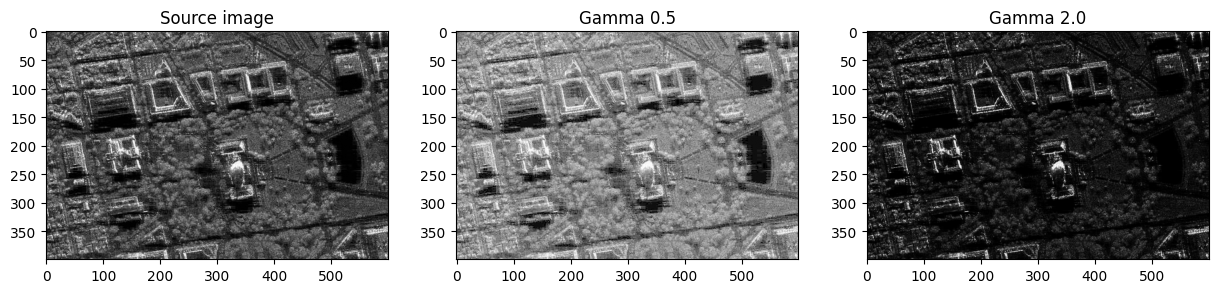

In [ ]:
# 3. реализуйте алгоритм гамма коррекции с параметром гамма <1, >1.

def gamma_correction(image, gamma):

    # Нормализуем в диапазон [0,1]
    normalized = image / 255.0
    
    # Применяем гамма-коррекцию
    corrected = np.power(normalized, gamma)
    
    # Возвращаем к диапазону [0,255]
    corrected = np.uint8(corrected * 255)
        
    return corrected


img_gamma_low  = gamma_correction(img, 0.5)  # гамма < 1
img_gamma_high = gamma_correction(img, 2.0)  # гамма > 1

fig, axs = plt.subplots(1, 3, figsize=(15,6))

axs[0].imshow(img, cmap='gray')
axs[0].set_title("Source image")

axs[1].imshow(img_gamma_low, cmap='gray')
axs[1].set_title("Gamma 0.5")

axs[2].imshow(img_gamma_high, cmap='gray')
axs[2].set_title("Gamma 2.0")

plt.show()


In [8]:
# 4. Сравните исходное изображение, скорректированное при помощи гамма-фильтра. MSE, SSIM.

from math import sqrt

def mse(img1, img2):
    return np.mean((img1.astype("float") - img2.astype("float")) ** 2)

# Простая реализация SSIM для grayscale
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    mu1 = cv2.GaussianBlur(img1, (11,11), 1.5)
    mu2 = cv2.GaussianBlur(img2, (11,11), 1.5)

    sigma1_sq = cv2.GaussianBlur(img1*img1, (11,11), 1.5) - mu1**2
    sigma2_sq = cv2.GaussianBlur(img2*img2, (11,11), 1.5) - mu2**2
    sigma12   = cv2.GaussianBlur(img1*img2, (11,11), 1.5) - mu1*mu2

    ssim_map = ((2*mu1*mu2 + C1) * (2*sigma12 + C2)) / ((mu1**2 + mu2**2 + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

print("Gamma 0.5 -> MSE:", mse(img, img_gamma_low), "SSIM:", ssim(img, img_gamma_low))
print("Gamma 2.0 -> MSE:", mse(img, img_gamma_high), "SSIM:", ssim(img, img_gamma_high))






Gamma 0.5 -> MSE: 3250.429145833333 SSIM: 0.7826855938698241
Gamma 2.0 -> MSE: 2383.7636375 SSIM: 0.5193678832134501


In [11]:
# 4. Сравните исходное изображение, скорректированное при помощи гамма-фильтра. MSE, SSIM.

from skimage.metrics import structural_similarity, mean_squared_error

(ssim, diff) = structural_similarity(img, img_gamma_high, full=True)
diff = (diff * 255).astype("uint8")

mse = mean_squared_error(img, img_gamma_high)

print(f"SSIM: {ssim}")
print(f"MSE: {mse}")


SSIM: 0.5270459922820344
MSE: 2383.7636375


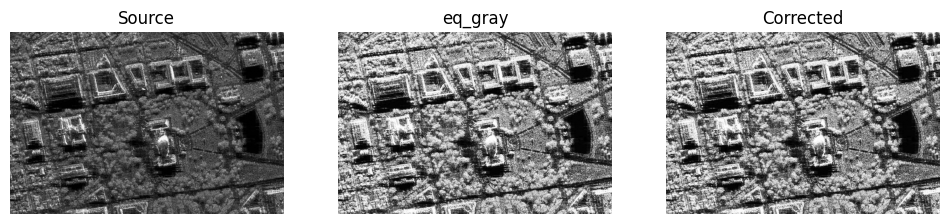

In [13]:
# 5. реализуйте алгоритм статистической цветокоррекции на основе статистики eq_gray.


def color_correction(img):
    
    # Считаем гистограмму
    hist, bins = np.histogram(img.flatten(), 256, [0,256])
    
    # Кумулятивная сумма (CDF)
    cdf = hist.cumsum()
    
    # Нормализация CDF в диапазон [0,255]
    cdf_normalized = 255 * (cdf - cdf.min()) / (cdf.max() - cdf.min())
    cdf_normalized = cdf_normalized.astype(np.uint8)
    
    # Применяем к изображению
    img_eq = cdf_normalized[img]

    return img_eq;

# mean_src, std_src = img.mean(), img.std()
# mean_ref, std_ref = eq_gray.mean(), eq_gray.std()

# stat_corrected = (img.astype(np.float64) - mean_src) * (std_ref/std_src) + mean_ref
# stat_corrected = np.clip(stat_corrected, 0, 255).astype(np.uint8)


eq_gray = cv2.equalizeHist(img)
stat_corrected = color_correction(img)

fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title("Source")
axs[0].axis("off")

axs[1].imshow(eq_gray, cmap='gray')
axs[1].set_title("eq_gray")
axs[1].axis("off")

axs[2].imshow(stat_corrected, cmap='gray')
axs[2].set_title("Corrected")
axs[2].axis("off")
plt.show()


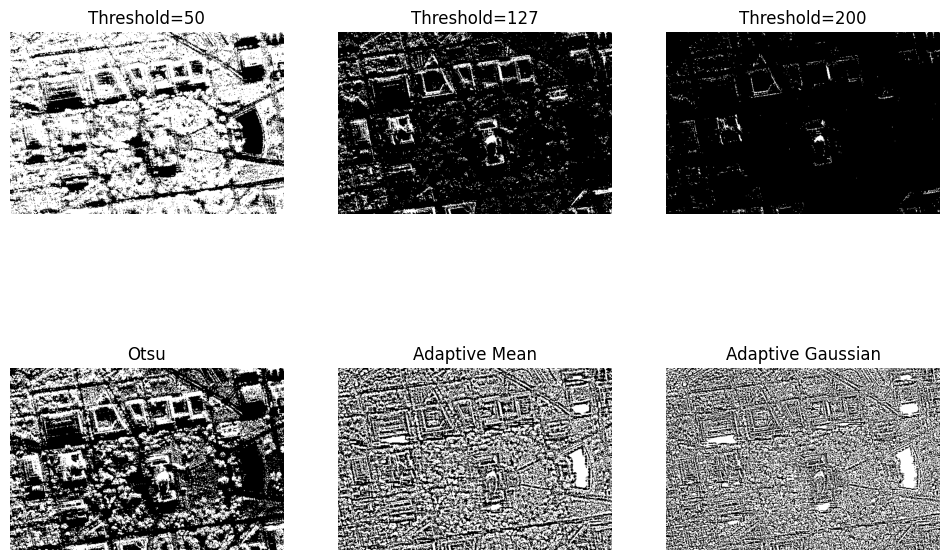

In [16]:
# 6. Протестируйте работу алгоритмов пороговой фильтрации с различными параметрами.

# Глобальные пороги
_, th1 = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
_, th2 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
_, th3 = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)

# Otsu
_, th_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Адаптивные методы
th_adapt_mean = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                      cv2.THRESH_BINARY, 11, 5)
th_adapt_gauss = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 5)

fig, axs = plt.subplots(2,3, figsize=(12,8))
axs[0,0].imshow(th1, cmap='gray'); axs[0,0].set_title("Threshold=50"); axs[0,0].axis("off")
axs[0,1].imshow(th2, cmap='gray'); axs[0,1].set_title("Threshold=127"); axs[0,1].axis("off")
axs[0,2].imshow(th3, cmap='gray'); axs[0,2].set_title("Threshold=200"); axs[0,2].axis("off")
axs[1,0].imshow(th_otsu, cmap='gray'); axs[1,0].set_title("Otsu"); axs[1,0].axis("off")
axs[1,1].imshow(th_adapt_mean, cmap='gray'); axs[1,1].set_title("Adaptive Mean"); axs[1,1].axis("off")
axs[1,2].imshow(th_adapt_gauss, cmap='gray'); axs[1,2].set_title("Adaptive Gaussian"); axs[1,2].axis("off")
plt.show()
